# This notebook explores the Energy Preserving Neural Network Idea!
-------------------------------------------------------------------------------------------------------------------
# Dataset used => MNIST
-------------------------------------------------------------------------------------------------------------------
# Technology used => TensorFlow

## This network has only one hidden layer, but more number of neurons in the hidden layer

### This network is only two layers deep: With a single hidden layer

In [1]:
# import all the required packages: 
# packages used for processing: 
from __future__ import print_function # making backward compatible

import matplotlib.pyplot as plt # for visualization
import numpy as np

# THE TensorFlow framework
import tensorflow as tf
# use the tensorflow's archived version of the MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data

# for operating system related stuff
import os
import sys # for memory usage of objects
from subprocess import check_output

# to plot the images inline
%matplotlib inline

In [2]:
# Input data files are available in the "../Data/" directory.

def exec_command(cmd):
    '''
        function to execute a shell command and see it's 
        output in the python console
        @params
        cmd = the command to be executed along with the arguments
              ex: ['ls', '../input']
    '''
    print(check_output(cmd).decode("utf8"))

In [3]:
# check the structure of the project directory
exec_command(['ls', '../..'])

Data
Error_analysis
LICENSE
Literature_survey
Models
README.md
Res
Scripts



In [4]:
# set a seed value for the script
seed_value = 3

In [5]:
np.random.seed(seed_value) # set this seed for a device independant consistent behaviour

In [6]:
''' Set the constants for the script '''

# various paths of the files
base_data_path = "../../Data" # the data path

base_model_path = "../../Models/IDEA_3"

# constant values for the script
num_digits = 10 # This is defined. There are 10 labels for 10 digits
img_dim = 28 # images are 28 x 28 sized
num_channels = 1 # images are grayscale

In [7]:
# Hyper parameters for tweaking.
# =================================================================================================================
training_batch_size = 64 # 64 images in each batch
no_of_epochs = 50


# network architecture related parameters:
''' Note that the number of layers will be fixed. you can tweak the number of hidden neurons in these layers: '''
num_hidden_lay_1 = 1024
num_hidden_lay_2 = num_digits

# learning rate required for other optimizers:
learning_rate = 3e-4 # lolz! the karpathy constant
# =================================================================================================================

In [8]:
mnist = input_data.read_data_sets(os.path.join(base_data_path, "MNIST_data"), seed=seed_value, one_hot=True)

Extracting ../../Data/MNIST_data/train-images-idx3-ubyte.gz
Extracting ../../Data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../../Data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../../Data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [9]:
train_X = mnist.train.images; train_Y = mnist.train.labels
dev_X = mnist.validation.images; dev_Y = mnist.validation.labels
test_X = mnist.test.images; test_Y = mnist.test.labels

In [10]:
# print all the shapes:
print("Training Data shapes: ", train_X.shape, train_Y.shape)
print("Development Data shapes: ", dev_X.shape, dev_Y.shape)
print("Test Data shapes: ", test_X.shape, test_Y.shape)

Training Data shapes:  (55000, 784) (55000, 10)
Development Data shapes:  (5000, 784) (5000, 10)
Test Data shapes:  (10000, 784) (10000, 10)


In [11]:
# define the total_train_examples, total_dev_examples and the total_test_examples using the above arrays
total_train_examples = train_X.shape[0]
total_dev_examples = dev_X.shape[0]
total_test_examples = test_X.shape[0]
input_dimension = train_X.shape[1]

In [12]:
# just double checking if all the values are correct:
print("Training_data_size =", total_train_examples)
print("Development_data_size =", total_dev_examples)
print("Test_data_size =", total_test_examples)
print("Input data dimensions =", input_dimension)

Training_data_size = 55000
Development_data_size = 5000
Test_data_size = 10000
Input data dimensions = 784


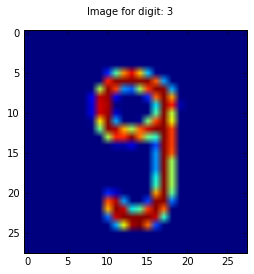

In [13]:
''' Randomized cell: Behaviour changes upon running multiple times '''

random_index = np.random.randint(total_train_examples)

# bring the random image from the training data
random_image = train_X[random_index].reshape((img_dim, img_dim))
label_for_random_image = np.argmax(train_Y[random_index])

# display this random image:
plt.figure().suptitle("Image for digit: " + str(label_for_random_image))
plt.imshow(random_image);

## Experimentation: 

In this notebook, I'll compare three different versions of neural networks. First is the usual neural network that uses batch_normalization and ReLU's everywhere. Second is the scattering network that fully preserves the energy (norm) of the input vector. Third is the hybrid of the two. 

In [14]:
tf.reset_default_graph()

In [15]:
# define the placeholders for the model:
with tf.name_scope("Input_Placeholders"):
    tf_input_images = tf.placeholder(tf.float32, shape=(None, input_dimension), name="input_images")
    tf_input_labels = tf.placeholder(tf.float32, shape=(None, num_digits), name="input_labels")
    
    # add input images summary:
    input_image_summary = tf.summary.image("Input_images", 
                                    tf.reshape(tf_input_images, shape=(-1, img_dim, img_dim, num_channels)))

define the three layers for the modified neural network:

In [16]:
# define the first layer: 
with tf.variable_scope("layer_1"):
    # create the matrix variable
    lay_1_connections = tf.get_variable("lay1_connections", shape=(num_hidden_lay_1, input_dimension), 
                                    dtype=tf.float32, initializer=tf.truncated_normal_initializer(seed=seed_value))
    
    with tf.name_scope("transformed_weights"):
        transformed_lay_1_connections = tf.nn.softmax(lay_1_connections, dim=0, name="softmax")
    
    # define the outputs of the layer1:
    lay_1_out = tf.matmul(transformed_lay_1_connections, 
                                        tf.transpose(tf_input_images)) # This is a simple matmul! no biases req.
    
    # add histogram summary over the lay_1_connections:
    lay_1_connections_summary = tf.summary.histogram("lay_1_connections", lay_1_connections)

In [17]:
# print the tensor shape of the lay_1_out
print("Layer_1 output:", lay_1_out)

Layer_1 output: Tensor("layer_1/MatMul:0", shape=(1024, ?), dtype=float32)


In [18]:
# define the second layer: 
with tf.variable_scope("layer_2"):
    # create the matrix variable
    lay_2_connections = tf.get_variable("lay2_connections", shape=(num_hidden_lay_2, num_hidden_lay_1), 
                                    dtype=tf.float32, initializer=tf.truncated_normal_initializer(seed=seed_value))
    
    with tf.name_scope("transformed_weights"):
        transformed_lay_2_connections = tf.nn.softmax(lay_2_connections, dim=0, name="softmax")
    
    # define the outputs of the layer2:
    lay_2_out = tf.matmul(transformed_lay_2_connections, 
                                        lay_1_out) # This is a simple matmul! no biases req.
    
    lay_2_connections_summary = tf.summary.histogram("lay_2_connections", lay_2_connections)

In [19]:
# print the tensor shape of the lay_2_out
print("Layer_2 output:", lay_2_out)

Layer_2 output: Tensor("layer_2/MatMul:0", shape=(10, ?), dtype=float32)


In [20]:
# define the predictions obtained from these computations:
with tf.name_scope("Predictions"):
    predictions = tf.nn.softmax(tf.transpose(lay_2_out))

In [21]:
# print the shape of the predictions:
print("Predictions:", predictions)

Predictions: Tensor("Predictions/Softmax:0", shape=(?, 10), dtype=float32)


define the loss for optimization:

In [22]:
# loss definition:
with tf.name_scope("Loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=tf.transpose(lay_2_out), 
                                                                              labels=tf_input_labels))
    
    # attach a scalar summary over this:
    loss_summary = tf.summary.scalar("Loss", loss)

In [23]:
# define the accuracy calculation module:
with tf.name_scope("Accuracy"):
    correct = tf.equal(tf.argmax(predictions, axis=-1), tf.argmax(tf_input_labels, axis=-1))
    accuracy = tf.reduce_mean(tf.cast(correct, dtype=tf.float32))
    
    # attach a scalar summary for the accuracy calculates
    accuracy_summary = tf.summary.scalar("Accuracy", accuracy)

In [24]:
# define the trainer of the operation
with tf.name_scope("Trainer"):
    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [25]:
# define the tensorflow errands
with tf.name_scope("Errands"):
    init = tf.global_variables_initializer()
    all_summaries = tf.summary.merge_all()

### Start the session to train the model

In [ ]:
# define the model to train: 
model_name = "Model_fully_energy_preserving_1_deep_1024_wide"
# generate the model saving path:
model_save_path = os.path.join(base_model_path, model_name)

In [ ]:
with tf.Session() as sess:
    
    # create a tensorboard writer
    tensorboard_writer = tf.summary.FileWriter(logdir=model_save_path, graph=sess.graph, filename_suffix=".bot")
    
    # create a saver
    saver = tf.train.Saver(max_to_keep=3)
    
    # restore the session if the checkpoint exists:
    if(os.path.isfile(os.path.join(model_save_path, "checkpoint"))):
        saver.restore(sess, tf.train.latest_checkpoint(model_save_path))
    
    else: # initialize all the variables:
        sess.run(init)
    
    global_step = 0
    print("Starting the training process . . .")
    for epoch in range(no_of_epochs):
        
        # run through the batches of the data:
        accuracies = [] # initialize this to an empty list
        for batch in range(int(np.ceil(float(total_train_examples) / training_batch_size))):
            start = batch * training_batch_size; end = start + training_batch_size
            
            # extract the relevant data:
            batch_data_X = train_X[start: end]
            batch_data_Y = train_Y[start: end]
        
            # This is batch gradient descent:
            _, cost, acc, sums = sess.run([train_step, loss, accuracy, all_summaries], 
                                                    feed_dict={tf_input_images: batch_data_X, 
                                                              tf_input_labels: batch_data_Y})
            
            # append the acc to the accuracies list
            accuracies.append(acc)
            
            # save the summarys
            tensorboard_writer.add_summary(sums, global_step)
            
            # increment the global step 
            global_step += 1
            
        print("epoch =", epoch, "\tcost =", cost)
        
        # evaluate the accuracy of the training epoch:
        print("accuracy =", sum(accuracies) / len(accuracies))
        
        # evaluate the dev-set accuracy: 
        dev_acc = sess.run(accuracy, feed_dict={tf_input_images: dev_X, tf_input_labels: dev_Y})
        print("Obtained Dev accuracy = ", dev_acc)
        
        # save the model after every epoch
        saver.save(sess, os.path.join(model_save_path, model_name), global_step=(epoch + 10))
        
    print("Training complete . . .")
    
    # Once, the training is complete:
    # print the test accuracy:
    test_acc = sess.run(accuracy, feed_dict={tf_input_images: test_X, tf_input_labels: test_Y})
    print("Obtained Test accuracy = ", test_acc)

Starting the training process . . .
epoch = 0 	cost = 2.0741
accuracy = 0.286428052326
Obtained Dev accuracy =  0.5148
epoch = 1 	cost = 1.86008
accuracy = 0.660925387574
Obtained Dev accuracy =  0.7192
epoch = 2 	cost = 1.63675
accuracy = 0.74320494186
Obtained Dev accuracy =  0.7656
epoch = 3 	cost = 1.41663
accuracy = 0.768798449636
Obtained Dev accuracy =  0.78
epoch = 4 	cost = 1.21733
accuracy = 0.78515625
Obtained Dev accuracy =  0.792
epoch = 5 	cost = 1.04806
accuracy = 0.797414001961
Obtained Dev accuracy =  0.805
epoch = 6 	cost = 0.908554
accuracy = 0.808236434085
Obtained Dev accuracy =  0.8188
epoch = 7 	cost = 0.794435
accuracy = 0.816460755814
Obtained Dev accuracy =  0.8284
epoch = 8 	cost = 0.700835
accuracy = 0.82289244186
Obtained Dev accuracy =  0.8366
epoch = 9 	cost = 0.6236
accuracy = 0.829342296512
Obtained Dev accuracy =  0.8422
epoch = 10 	cost = 0.559453
accuracy = 0.834284156977
Obtained Dev accuracy =  0.847
epoch = 11 	cost = 0.505851
accuracy = 0.8393350